## The purpose is to predict the rating of each movies or TV-series

### 1 - Introduction phase: importing the data set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
import seaborn as sb
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from operator import itemgetter

In [3]:
data = pd.read_table('D:\\Python Projects\\IMDB 2\\movie_metadata.csv', sep= ',')
print(len(data.index))
data.columns

5043


Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [4]:
f_data=data.drop(['aspect_ratio', 'movie_imdb_link'], axis=1)   
   # ----->  I believe these features are not improving the prediction process!

## Numeric Features
numeric_features=f_data._get_numeric_data().columns.tolist()


## All non-numeric columns but they are not neccesarily categorical features
text_features=f_data.columns.tolist()
text_features=[i for i in text_features if i not in numeric_features]


## Categorical Features
str_features=['movie_title', 'plot_keywords']
categoric_features= [i for i in text_features if i not in str_features]


numeric_features.remove('imdb_score')                                     # -----> it's the lable that we want to predict
categoric_features.remove('content_rating')                               # -----> I think this feature is irrelevant
numeric_features.remove('title_year')   
categoric_features.append('title_year')

''' I added title_year to categorical features - for now - but I don't want to make columns based on its dummies values, 
     instead I want to examine if it should be standardized or not '''

" I added title_year to categorical features - for now - but I don't want to make columns based on its dummies values, \n     instead I want to examine if it should be standardized or not "

In [5]:
print('-------'*20)
print('\033[1m numeric features are:\033[0m','\n', numeric_features)
print('-------'*20)
print('\033[1m categorical features are:\033[0m', '\n',  categoric_features)
print('-------'*20)

--------------------------------------------------------------------------------------------------------------------------------------------
 numeric features are: 
 ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'budget', 'actor_2_facebook_likes', 'movie_facebook_likes']
--------------------------------------------------------------------------------------------------------------------------------------------
 categorical features are: 
 ['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name', 'actor_3_name', 'language', 'country', 'title_year']
--------------------------------------------------------------------------------------------------------------------------------------------


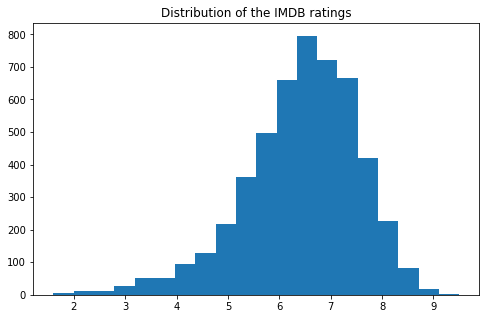

In [6]:
plt.figure(figsize=(8,5))
plt.hist(f_data.imdb_score, bins=20)
plt.title('Distribution of the IMDB ratings')
plt.show()

### 2 - numeric features manipulations

##### 2 - 1 - missing values and normalizing

In [7]:
## dealing with missing values
imp= Imputer(missing_values='NaN', strategy= 'most_frequent', axis=0)
f_data[numeric_features]=imp.fit_transform(f_data[numeric_features])

## normalizing the numeric features
scl = StandardScaler()
f_data[numeric_features]=scl.fit_transform(f_data[numeric_features])

## and changing the original data set to fill the missing values for future uses without normalizing
data[numeric_features]=imp.fit_transform(data[numeric_features])

##### 2 - 2 - Checking the correlations

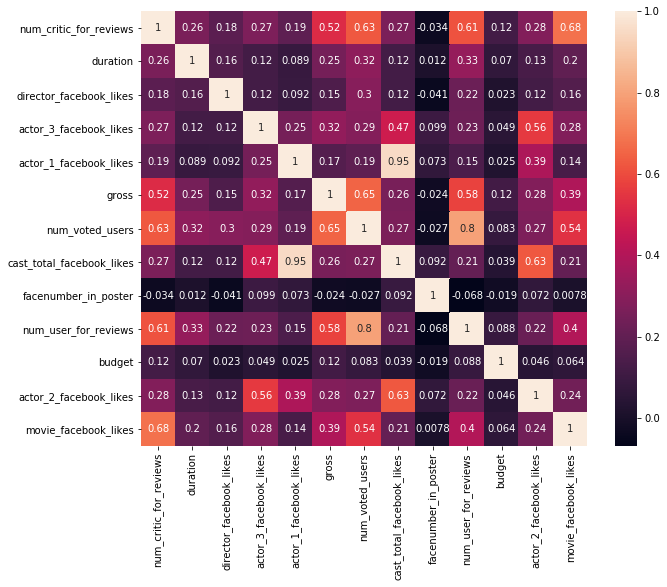

In [8]:
len_numeric=len(numeric_features)
corr_num_features = np.zeros((len_numeric,len_numeric))    # the matrix of correlation between all numeric_features

## filling the correlation matrix
for h, i in enumerate(numeric_features):
    for k, j in enumerate(numeric_features):
        cor_1,_ = pearsonr(f_data[i],f_data[j])
        corr_num_features[h][k]=cor_1
        
corr_2=pd.DataFrame(corr_num_features, index=numeric_features, columns= numeric_features)

### Plotting
plt.figure(figsize= (10,8))                   
sb.heatmap(corr_2, annot= True)                
plt.show()

-  cast_total_facebook_likes & actor_1_facebook_likes & actor_2_facebook_likes & actor_3_facebook_likes  -----> have correlations with each others
- gross & num_critic_for_reviews & num_user_for_reviews & num_voted_users & movie_facebook_likes        -----> have correlations with each others

- So, we make a new column named "movie_success" based on "goss", "num_critic_for_reviews", "num_user_for_reviews", 
  "num_voted_users" and " movie_facebook_likes". 
  Then we delete these features from numeric features to not participate
   them in calculation process any further.

- and we do the same for facebook likes: we create "other_actors_facebook_likes" feature based on "actor_2_facebook_likes" 
  and "actor_3_facebook_likes" and delete them too.

In [9]:
f_data['movie_success']=(f_data['gross']+f_data['num_critic_for_reviews']+f_data['num_user_for_reviews']
                        +f_data['num_voted_users']+f_data['movie_facebook_likes'])/5

f_data['other_actors_facebook_likes']=f_data['actor_2_facebook_likes']+f_data['actor_3_facebook_likes']

''' P.S. we don't remove the columns from dataset, instead it is wiser if we just update the numeric_features list and  
  make use of that list to make calculations.'''

numeric_features_2 = [i for i in numeric_features if i not in ['gross', 'num_critic_for_reviews', 'num_user_for_reviews', 
                                                               'num_voted_users', 'cast_total_facebook_likes', 
                                                               'movie_facebook_likes','actor_2_facebook_likes', 
                                                               'actor_3_facebook_likes']]
numeric_features_2.extend(["movie_success", "other_actors_facebook_likes"])

In [11]:
print('------'*20)
print('\033[1m new numeric features are:\033[0m','\n', numeric_features_2)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 new numeric features are: 
 ['duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'facenumber_in_poster', 'budget', 'movie_success', 'other_actors_facebook_likes']
------------------------------------------------------------------------------------------------------------------------


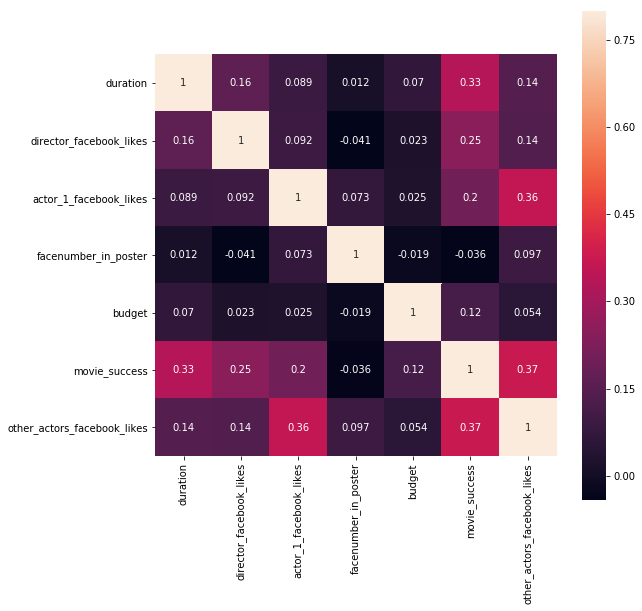

In [12]:
corr_num_features_2 = np.zeros((len(numeric_features_2),len(numeric_features_2)))
for h, i in enumerate(numeric_features_2):
    for k, j in enumerate(numeric_features_2):
        cor_1,_ = pearsonr(f_data[i],f_data[j])
        corr_num_features_2[h][k]=cor_1
        
corr_3=pd.DataFrame(corr_num_features_2, index=numeric_features_2, columns= numeric_features_2)
plt.figure(figsize=(9,9))
sb.heatmap(corr_3, vmax=.8, square=True, annot=True)
plt.show()

- Correlation of the numeric features with the IMDb score

In [13]:
correl_2=[]
for i in numeric_features_2:
    cor_4, _= pearsonr(f_data[i],f_data.imdb_score)
    correl_2.append(cor_4)
    
correl_2 = pd.DataFrame([round(n, 3) for n in correl_2], index=numeric_features_2)
correl_2

,0
duration,0.261
director_facebook_likes,0.162
actor_1_facebook_likes,0.076
facenumber_in_poster,-0.062
budget,0.027
movie_success,0.349
other_actors_facebook_likes,0.077


### 3 - categorical features preprations

####  3 - 1 - Director_names segmentation

In [14]:
directors=pd.DataFrame(data.groupby('director_name')['director_facebook_likes'].sum())
directors['dir_class']=pd.cut(directors.director_facebook_likes,
                             bins=[-1, 50, 1000, 200000000],
                             labels=["low popularity", "medium popularity","high popularity"])

directors_2 = directors.drop('director_facebook_likes', axis=1)
directors_2['director_name']=directors_2.index
directors_2.reset_index(drop=True, inplace=True)
directors_2.head()

,dir_class,director_name
0,low popularity,A. Raven Cruz
1,low popularity,Aaron Hann
2,low popularity,Aaron Schneider
3,medium popularity,Aaron Seltzer
4,medium popularity,Abel Ferrara


_"then according to each director's name we create a column named dir-class"_

In [15]:
f_data=pd.merge(f_data,directors_2, on='director_name', how='left')
print(len(f_data.index))
f_data.dir_class.value_counts()

5043


low popularity       2092
medium popularity    1774
high popularity      1073
Name: dir_class, dtype: int64

- updating categorical features

In [16]:
categoric_features.append('dir_class')
categoric_features.remove('director_name')

print('------'*20)
print('\033[1m new categorical features are:\033[0m','\n', categoric_features)
print('------'*20)

--------------------------------------------------------------------------------------------------------------------------------------------
 new categorical features are: 
 ['color', 'actor_2_name', 'genres', 'actor_1_name', 'actor_3_name', 'language', 'country', 'title_year', 'dir_class']
--------------------------------------------------------------------------------------------------------------------------------------------


#### 3 - 2 - Actors segmentation

In [17]:
actor_1=data[['actor_1_name','actor_1_facebook_likes']]
actor_1.columns=['actor_name', 'facebook_likes']

actor_2=data[['actor_2_name','actor_2_facebook_likes']]
actor_2.columns=['actor_name', 'facebook_likes']

actor_3 =data[['actor_3_name','actor_3_facebook_likes']]
actor_3.columns=['actor_name', 'facebook_likes']

actors=pd.concat([actor_1, actor_2, actor_3], axis=0)
actors_total= pd.DataFrame(actors.groupby('actor_name')['facebook_likes'].mean().round(0))


actors_total['class']=pd.cut(actors_total.facebook_likes,
                             bins=[-1, 300, 5000, 2000000],
                             labels=["low popularity", "medium popularity","high popularity"])
actors_total['name']=actors_total.index
actors_total_2=actors_total.drop('facebook_likes', axis=1)
actors_total_2.reset_index(drop=True, inplace=True)
actors_total_2.columns

Index(['class', 'name'], dtype='object')

- replacing the actors segmentations

In [18]:
actors_name=['actor_1_name', 'actor_2_name', 'actor_3_name' ]
actors_class=['actor_1_class', 'actor_2_class', 'actor_3_class']
for i,j in enumerate(actors_name):
    actors_total_2.columns=[actors_class[i], j]
    f_data=pd.merge(f_data, actors_total_2, on= j, how='left')

In [19]:
print('------'*20)
print('\033[1m the count of values in actor_1_class are:\033[0m','\n', f_data.actor_1_class.value_counts())
print('------'*20)
print('\033[1m the count of values in actor_2_class are:\033[0m','\n', f_data.actor_2_class.value_counts())
print('------'*20)
print('\033[1m the count of values in actor_3_class are:\033[0m','\n', f_data.actor_3_class.value_counts())
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 the count of values in actor_1_class are: 
 medium popularity    2871
high popularity      1592
low popularity        573
Name: actor_1_class, dtype: int64
------------------------------------------------------------------------------------------------------------------------
 the count of values in actor_2_class are: 
 medium popularity    3291
low popularity       1331
high popularity       408
Name: actor_2_class, dtype: int64
------------------------------------------------------------------------------------------------------------------------
 the count of values in actor_3_class are: 
 medium popularity    2730
low popularity       2191
high popularity        99
Name: actor_3_class, dtype: int64
------------------------------------------------------------------------------------------------------------------------


- updating categorical features

In [20]:
categoric_features_2=categoric_features.copy()

# appending
categoric_features_2.extend(['actor_1_class', 'actor_2_class', 'actor_3_class'])

# removing
categoric_features_2.remove('actor_1_name')
categoric_features_2.remove('actor_2_name')
categoric_features_2.remove('actor_3_name')

print('------'*20)
print('\033[1m new categorical features are:\033[0m','\n', categoric_features_2)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 new categorical features are: 
 ['color', 'genres', 'language', 'country', 'title_year', 'dir_class', 'actor_1_class', 'actor_2_class', 'actor_3_class']
------------------------------------------------------------------------------------------------------------------------


#### 3 - 3 - genres edition

In [21]:
genre_list=['Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery', 'Crime', 'Biography', 'Fantasy', 
            'Documentary', 'Sci-Fi', 'Horror', 'Romance', 'Thriller', 'Family', 'Music', 'Western', 'Musical', 
            'Film-Noir', 'History', 'War', 'Sport', 'News', 'Game-Show', 'Reality-TV', 'Short']

- creating a column for each genre in genre_list with the zero value

In [22]:
for gen in genre_list:
    my_len=len(f_data.columns)
    f_data.insert(my_len, gen,0)
    categoric_features_2.append(gen)

- based on genre column in f_data filling these columns with 1 value

In [23]:
for i in (f_data.index):
    gen1=f_data.genres[i]
    gen2=gen1.split('|')
    for g in gen2:
        f_data.at[i, g]=1
f_data[genre_list].sum() 

Action         1153
Adventure       923
Drama          2594
Animation       242
Comedy         1872
Mystery         500
Crime           889
Biography       293
Fantasy         610
Documentary     121
Sci-Fi          616
Horror          565
Romance        1107
Thriller       1411
Family          546
Music           214
Western          97
Musical         132
Film-Noir         6
History         207
War             213
Sport           182
News              3
Game-Show         1
Reality-TV        2
Short             5
dtype: int64

- updating categorical features

In [24]:
categoric_features_2.remove('genres')

print('------'*20)
print('\033[1m new categorical features are:\033[0m','\n', categoric_features_2)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 new categorical features are: 
 ['color', 'language', 'country', 'title_year', 'dir_class', 'actor_1_class', 'actor_2_class', 'actor_3_class', 'Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery', 'Crime', 'Biography', 'Fantasy', 'Documentary', 'Sci-Fi', 'Horror', 'Romance', 'Thriller', 'Family', 'Music', 'Western', 'Musical', 'Film-Noir', 'History', 'War', 'Sport', 'News', 'Game-Show', 'Reality-TV', 'Short']
------------------------------------------------------------------------------------------------------------------------


#### 3 - 4 - deleting missing values based on categorical features

In [25]:
f_data_2=f_data.dropna()
f_data_2.reset_index(drop=True, inplace=True)

#### 3 - 5 - deleting some rows based on categorical features

##### 3 - 5 - 1 - deleting based on countries

- deleting some rows based on the country column.
> I want to delete movies (rows) which are from countries that we have less than 10 movies from them. it's because if we want to consider country of origin in order to predict the rating, there should be enough data from that country to able the model predict the behavior of target based on that country.

- the more movies from each country, the more exact model would be achieved, for now, we consider the minimum 9 movies for each country.

In [26]:
My_country=pd.DataFrame(f_data_2.country.value_counts())
country_1=My_country[My_country<10]
country_1.dropna(inplace=True)
country_to_delete = country_1.index.tolist()

print('------'*20)
print("\033[1m Number of countries which do not have enough data and need to be deleted are:\033[0m", '\n',
      len(country_to_delete))
print('------'*20)
print("\033[1m selected countries to be deleted are:\033[0m", '\n', country_to_delete)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 Number of countries which do not have enough data and need to be deleted are: 
 38
------------------------------------------------------------------------------------------------------------------------
 selected countries to be deleted are: 
 ['South Africa', 'Norway', 'Russia', 'Brazil', 'Thailand', 'Netherlands', 'Iran', 'Argentina', 'West Germany', 'Belgium', 'Czech Republic', 'Israel', 'Sweden', 'Hungary', 'Romania', 'Greece', 'Taiwan', 'Poland', 'Bulgaria', 'Afghanistan', 'Colombia', 'Libya', 'Bahamas', 'Aruba', 'New Line', 'Philippines', 'Official site', 'Indonesia', 'Finland', 'Panama', 'Peru', 'Soviet Union', 'Iceland', 'Switzerland', 'Chile', 'Slovakia', 'Kyrgyzstan', 'Georgia']
------------------------------------------------------------------------------------------------------------------------


In [27]:
f_data_3=f_data_2.copy(deep=True)
for i in country_to_delete:
    j=int(country_1.loc[i][0])
    for h in range(j):
        f_data_3.drop(f_data_3[f_data_3.country == i].index.astype(int)[0], axis=0, inplace=True)

print('------'*20)        
print("\033[1m The remained countries and the number of their movies in data set are:\033[0m", "\n",
      f_data_3.country.value_counts())
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 The remained countries and the number of their movies in data set are: 
 USA            3535
UK              412
France          130
Canada          100
Germany          93
Australia        51
Spain            31
China            19
Japan            18
Italy            17
Hong Kong        15
India            13
New Zealand      13
Denmark          11
Ireland          11
South Korea      11
Mexico           10
Name: country, dtype: int64
------------------------------------------------------------------------------------------------------------------------


##### 3 - 4 - 2 - deleting based on Language

> The same explanation as countries is applies here as well

In [28]:
language= pd.DataFrame(f_data_3.language.value_counts())
language_1= language[language<10]
language_1.dropna(inplace=True)
language_to_delete=language_1.index

print('------'*20)
print("\033[1m Number of Languages which do not have enough data and need to be deleted are:\033[0m",
      '\n', len(language_to_delete))
print('------'*20)
print("\033[1m selected Languages to be deleted are:\033[0m", '\n', language_to_delete)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 Number of Languages which do not have enough data and need to be deleted are: 
 19
------------------------------------------------------------------------------------------------------------------------
 selected Languages to be deleted are: 
 Index(['Italian', 'Cantonese', 'Korean', 'Danish', 'Aboriginal', 'None',
       'Vietnamese', 'Filipino', 'Hebrew', 'Kazakh', 'Zulu', 'Arabic',
       'Persian', 'Maya', 'Aramaic', 'Dari', 'Portuguese', 'Bosnian',
       'Indonesian'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------------


In [29]:
for i in language_to_delete:
    j=int(language_1.loc[i][0])
    for h in range(j):
        f_data_3.drop(f_data_3[f_data_3.language == i].index.astype(int)[0], axis=0, inplace=True)
        
print('------'*20)        
print("\033[1m The remained Languages and the number of their movies in data set are:\033[0m", 
      "\n", f_data_3.language.value_counts())
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 The remained Languages and the number of their movies in data set are: 
 English     4310
French        49
Spanish       28
Mandarin      19
Hindi         14
Japanese      13
German        12
Name: language, dtype: int64
------------------------------------------------------------------------------------------------------------------------


##### 3 - 4 - 3 - deleting based on genres

In [30]:
genres_to_delete = pd.DataFrame(f_data_2[genre_list].sum())
genres_to_delete.columns=['cout_value']
genres_to_delete_2 = genres_to_delete[genres_to_delete<10]
genres_to_delete_2.dropna(axis=0, inplace=True)
genres_to_delete_1= genres_to_delete_2.index
genres_to_delete_2

,cout_value
Film-Noir,5.0
News,1.0
Game-Show,0.0
Reality-TV,0.0
Short,0.0


In [31]:
for i in genres_to_delete_1:
    j=int(genres_to_delete_2.loc[i][0])
    for h in range(j):
        f_data_3.drop(f_data_3[f_data_3[i] == 1].index.astype(int)[0], axis=0, inplace=True)


        
print('------'*20)        
print("\033[1m The remained Languages and the number of their movies in data set are:\033[0m", 
      "\n", f_data_3[genre_list].sum())
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 The remained Languages and the number of their movies in data set are: 
 Action         1050
Adventure       856
Drama          2241
Animation       220
Comedy         1710
Mystery         440
Crime           797
Biography       265
Fantasy         561
Documentary      70
Sci-Fi          566
Horror          506
Romance        1013
Thriller       1272
Family          497
Music           196
Western          83
Musical         121
Film-Noir         0
History         172
War             176
Sport           177
News              0
Game-Show         0
Reality-TV        0
Short             0
dtype: int64
------------------------------------------------------------------------------------------------------------------------


- updating the categorical features

In [33]:
genre_column_to_delete=pd.DataFrame(f_data_3[genre_list].sum())
genre_column_to_delete=genre_column_to_delete[genre_column_to_delete==0]
genre_column_to_delete.dropna(axis=0, inplace=True)
genre_column_to_delete=genre_column_to_delete.index
for i in genre_column_to_delete:
    categoric_features_2.remove(i)


print('------'*20)
print('\033[1m new categorical features are:\033[0m','\n', categoric_features_2)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 new categorical features are: 
 ['color', 'language', 'country', 'title_year', 'dir_class', 'actor_1_class', 'actor_2_class', 'actor_3_class', 'Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery', 'Crime', 'Biography', 'Fantasy', 'Documentary', 'Sci-Fi', 'Horror', 'Romance', 'Thriller', 'Family', 'Music', 'Western', 'Musical', 'History', 'War', 'Sport']
------------------------------------------------------------------------------------------------------------------------


- result of deleting some samples

In [35]:
print('------'*20)
print("In total\033[91m \033[1m{}\033[0m rows are deleted from the data set and the \033[91m\033[1m{}\033[0m \
rows are ready to feed into model".format(len(f_data.index)-len(f_data_3.index), len(f_data_3.index)))
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
In total 604 rows are deleted from the data set and the 4439 rows are ready to feed into model
------------------------------------------------------------------------------------------------------------------------


#### 3 - 6 - get dummies

In [36]:
cat_features_to_dummies=['color', 'language', 'country', 'dir_class', 'actor_1_class', 'actor_2_class', 'actor_3_class']

In [37]:
f_data_4 = pd.get_dummies(f_data_3[cat_features_to_dummies])
dummies_columns = f_data_4.columns.tolist()
f_data_5 = pd.concat([f_data_3, f_data_4], axis=1)

- updating categorical features

In [38]:
categoric_features_3 = categoric_features_2.copy()

for i in dummies_columns:
    categoric_features_3.append(i)

for j in cat_features_to_dummies:
    categoric_features_3.remove(j)  

print('------'*20)
print('\033[1m new categorical features are:\033[0m','\n', categoric_features_3)
print('------'*20)

------------------------------------------------------------------------------------------------------------------------
 new categorical features are: 
 ['title_year', 'Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery', 'Crime', 'Biography', 'Fantasy', 'Documentary', 'Sci-Fi', 'Horror', 'Romance', 'Thriller', 'Family', 'Music', 'Western', 'Musical', 'History', 'War', 'Sport', 'color_ Black and White', 'color_Color', 'language_English', 'language_French', 'language_German', 'language_Hindi', 'language_Japanese', 'language_Mandarin', 'language_Spanish', 'country_Australia', 'country_Canada', 'country_China', 'country_Denmark', 'country_France', 'country_Germany', 'country_Hong Kong', 'country_India', 'country_Ireland', 'country_Italy', 'country_Japan', 'country_Mexico', 'country_New Zealand', 'country_South Korea', 'country_Spain', 'country_UK', 'country_USA', 'dir_class_low popularity', 'dir_class_medium popularity', 'dir_class_high popularity', 'actor_1_class_low popular

### 4 - Feature selection based on the performance of model

- creating different groups of features to feed into model

In [39]:
features_group_1 = numeric_features_2.copy()
for i in categoric_features_3:
    features_group_1.append(i)

In [40]:
features_group_2=features_group_1.copy()
features_group_2.remove('director_facebook_likes')

In [41]:
features_group_3=features_group_1.copy()
features_group_3.remove('actor_1_facebook_likes')

In [42]:
features_group_4=features_group_1.copy()
features_group_4.remove('other_actors_facebook_likes')

In [43]:
features_group_5 = features_group_1.copy()
features_group_5.remove('movie_success')

In [44]:
features_group_6 = features_group_1.copy()
features_group_6.remove('facenumber_in_poster')

In [45]:
features_group_7 = features_group_1.copy()
features_group_7.remove('budget')

In [46]:
features_group_8 = features_group_1.copy()
features_group_8.remove('actor_1_facebook_likes')
features_group_8.remove('other_actors_facebook_likes')

In [48]:
features_group_9 = features_group_1.copy()
features_group_9.remove('actor_1_facebook_likes')
features_group_9.remove('other_actors_facebook_likes')
features_group_9.remove('director_facebook_likes')

In [49]:
features_group_10 = features_group_1.copy()
features_group_10.remove('actor_1_facebook_likes')
features_group_10.remove('other_actors_facebook_likes')
features_group_10.remove('director_facebook_likes')
features_group_10.remove('duration')

In [51]:
features_group_11 = features_group_1.copy()
features_group_11.remove('dir_class_low popularity')
features_group_11.remove('dir_class_medium popularity')
features_group_11.remove('dir_class_high popularity')

In [52]:
features_group_12 = features_group_1.copy()
features_group_12.remove('actor_2_class_low popularity')
features_group_12.remove('actor_2_class_medium popularity')
features_group_12.remove('actor_2_class_high popularity')
features_group_12.remove('actor_3_class_low popularity')
features_group_12.remove('actor_3_class_medium popularity')
features_group_12.remove('actor_3_class_high popularity')

In [53]:
features_group_13 = features_group_12.copy()
features_group_13.remove('dir_class_low popularity')
features_group_13.remove('dir_class_medium popularity')
features_group_13.remove('dir_class_high popularity')

In [54]:
features_group_14 = features_group_12.copy()
features_group_14.remove('actor_1_class_low popularity')
features_group_14.remove('actor_1_class_medium popularity')
features_group_14.remove('actor_1_class_high popularity')

In [55]:
feature_selection_mat = [features_group_1, features_group_2, features_group_3, features_group_4, features_group_5, 
                         features_group_6, features_group_7, features_group_8, features_group_9, features_group_10,
                         features_group_11, features_group_12, features_group_13, features_group_14]
groups_number=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [56]:
models =[]
rfr_s = []
clf_grid={}
param={'max_depth':[5,8,25], "min_samples_split":[2, 3, 5], "n_estimators":[800,1200]}
for j, i in enumerate(feature_selection_mat):
    x= f_data_5[i]
    y=f_data_5.imdb_score
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)
    RFR=RandomForestRegressor(max_features='sqrt')
    clf=GridSearchCV(RFR, param)
    clf.fit(x_train, y_train)
    models.append(clf)
    rfr_s.append(RFR)
    clf_grid [groups_number[j]] = clf.grid_scores_

- creating a function to report the best model

In [57]:
def mark_group_score(group_name, grid_score):
    final_score=[]
    for i in range(len(grid_score)):
        score=[]
        score.extend(grid_score[i])
        score.append(group_name)
        final_score.append(score)
    final_score_2=pd.DataFrame(final_score)
    final_score_2.columns=['param', 'mean', 'std_s', 'f_group_name']
    for j in range(len(final_score_2.index)):
        final_score_2.at[j,'mean']=final_score_2.loc[j,'std_s'].mean()
        final_score_2.at[j,'std']=np.std(final_score_2.loc[j,'std_s'])
    final_score_2.drop('std_s', axis=1, inplace=True)
    return final_score_2

In [58]:
top_scores=[]
n_top_from_each_group=3
for i in clf_grid:
    scores=clf_grid[i]
    sorted_score=mark_group_score(i, clf_grid[i]).sort_values('mean', ascending=False)
    for j in range(n_top_from_each_group):
        top_index=sorted_score.index[j]
        top_scores.append(dict(sorted_score.loc[top_index]))

top_score_df=pd.DataFrame(top_scores)    

### 5 - printing the results

In [66]:
feature_result=top_score_df.sort_values('mean',ascending=False)
feature_result.reset_index(drop=True, inplace=True)
selected_group = feature_result.loc[0, 'f_group_name']
selected_group_2=feature_result.loc[3, 'f_group_name']

In [67]:
print('------'*19)
print('\033[1m the 1st best feature group is the \033[91m {:}th \033[0m \033[1m group which are:\033[0m'.format(selected_group),'\n', \
      feature_selection_mat[selected_group-1])
print('------'*19)

------------------------------------------------------------------------------------------------------------------
 the 1st best feature group is the  14th   group which are: 
 ['duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'facenumber_in_poster', 'budget', 'movie_success', 'other_actors_facebook_likes', 'title_year', 'Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery', 'Crime', 'Biography', 'Fantasy', 'Documentary', 'Sci-Fi', 'Horror', 'Romance', 'Thriller', 'Family', 'Music', 'Western', 'Musical', 'History', 'War', 'Sport', 'color_ Black and White', 'color_Color', 'language_English', 'language_French', 'language_German', 'language_Hindi', 'language_Japanese', 'language_Mandarin', 'language_Spanish', 'country_Australia', 'country_Canada', 'country_China', 'country_Denmark', 'country_France', 'country_Germany', 'country_Hong Kong', 'country_India', 'country_Ireland', 'country_Italy', 'country_Japan', 'country_Mexico', 'country_New Zealand', 'country_Sout

In [68]:
print('---------'*10, '\n',
     'The performance of the 1st best model is as follow:', '\n', 
      '---------'*10, '\n',
      'the mean equals to:   {:.3f}'.format( feature_result.loc[0, 'mean']), '\n',
      '---------'*10, '\n',
      'std is            :   {:.3f}'.format(feature_result.loc[0, 'std']), '\n',
      '---------'*10, '\n',
      'the parameters are:   {}'.format(feature_result.loc[0, 'param']) , '\n' , 
     '---------'*10)

------------------------------------------------------------------------------------------ 
 The performance of the 1st best model is as follow: 
 ------------------------------------------------------------------------------------------ 
 the mean equals to:   0.486 
 ------------------------------------------------------------------------------------------ 
 std is            :   0.004 
 ------------------------------------------------------------------------------------------ 
 the parameters are:   {'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 800} 
 ------------------------------------------------------------------------------------------


In [72]:
print('------'*19)
print('\033[1m the 2nd best feature group is the \033[91m {:}th \033[0m \033[1m group which are:\033[0m'.format(selected_group_2),'\n', \
      feature_selection_mat[selected_group_2-1])
print('------'*19)

------------------------------------------------------------------------------------------------------------------
 the 2nd best feature group is the  9th   group which are: 
 ['duration', 'facenumber_in_poster', 'budget', 'movie_success', 'title_year', 'Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery', 'Crime', 'Biography', 'Fantasy', 'Documentary', 'Sci-Fi', 'Horror', 'Romance', 'Thriller', 'Family', 'Music', 'Western', 'Musical', 'History', 'War', 'Sport', 'color_ Black and White', 'color_Color', 'language_English', 'language_French', 'language_German', 'language_Hindi', 'language_Japanese', 'language_Mandarin', 'language_Spanish', 'country_Australia', 'country_Canada', 'country_China', 'country_Denmark', 'country_France', 'country_Germany', 'country_Hong Kong', 'country_India', 'country_Ireland', 'country_Italy', 'country_Japan', 'country_Mexico', 'country_New Zealand', 'country_South Korea', 'country_Spain', 'country_UK', 'country_USA', 'dir_class_low popularity', '

In [70]:
print('---------'*10, '\n',
     'The performance of the 2nd best model is as follow:', '\n', 
      '---------'*10, '\n',
      'the mean equals to:   {:.3f}'.format( feature_result.loc[2, 'mean']), '\n',
      '---------'*10, '\n',
      'std is            :   {:.3f}'.format(feature_result.loc[2, 'std']), '\n',
      '---------'*10, '\n',
      'the parameters are:   {}'.format(feature_result.loc[2, 'param']) , '\n' , 
     '---------'*10)

------------------------------------------------------------------------------------------ 
 The performance of the 2nd best model is as follow: 
 ------------------------------------------------------------------------------------------ 
 the mean equals to:   0.486 
 ------------------------------------------------------------------------------------------ 
 std is            :   0.005 
 ------------------------------------------------------------------------------------------ 
 the parameters are:   {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 1200} 
 ------------------------------------------------------------------------------------------


In [65]:
feature_result

,f_group_name,mean,param,std
0,14,0.485969,"{'max_depth': 25, 'min_samples_split': 3, 'n_e...",0.003890
1,14,0.485940,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.004790
2,14,0.485658,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.004699
3,9,0.484523,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.011920
4,9,0.484351,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.012440
5,8,0.482873,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.007264
6,9,0.482776,"{'max_depth': 25, 'min_samples_split': 3, 'n_e...",0.010455
7,13,0.482634,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.007773
8,8,0.482255,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.007446
9,13,0.481618,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",0.007167
